In [1]:
import os
import numpy as np
import pandas as pd 
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import tensorflow as tf

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR

from pdefind import *
from Model_Identification.PDE_Equation import pde_matrix_mul, sparse_coeff, normalized_xi_threshold, pde_Recover
from Model_Identification.build_Library import construct_Dictonary_2D


In [2]:
# Prepare dataset
data = sio.loadmat(os.path.join(os.getcwd(), "../data", "Advection_diffusion.mat"))
usol = np.real(data['Expression1'])
print('u.shape', usol.shape)
usol= usol.reshape((51,51,61,4))
#u = data["usol"]
x = usol[:,:,:,0]
y = usol[:,:,:,1]
t = usol[:,:,:,2]
u = usol[:,:,:,3]
print('u.shape', u.shape)
print('x.shape', x.shape)
print('t.shape', t.shape)
print('y.shape', y.shape)
print(x[:,:,10].shape)


u.shape (634644, 1)
u.shape (51, 51, 61)
x.shape (51, 51, 61)
t.shape (51, 51, 61)
y.shape (51, 51, 61)
(51, 51)


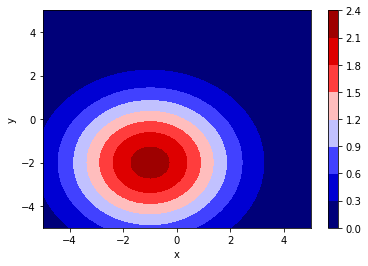

In [3]:
fig, ax = plt.subplots()

im = ax.contourf(x[:,:,10], y[:,:,10], u[:,:,10], cmap='seismic')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.colorbar(mappable=im)

plt.show()

In [4]:
X = np.transpose((t.flatten(),x.flatten(), y.flatten()))
Y = u.reshape((u.size, 1))
print(X.shape, Y.shape)
print('X:', X)

(158661, 3) (158661, 1)
X: [[ 3.  -5.  -5. ]
 [ 3.1 -5.  -5. ]
 [ 3.2 -5.  -5. ]
 ...
 [ 8.8  5.   5. ]
 [ 8.9  5.   5. ]
 [ 9.   5.   5. ]]


In [5]:
# Add noise
np.random.seed(0)
noise_level = 0.01
y = Y + noise_level * np.std(Y) * np.random.randn(Y.size, 1)



In [6]:
idxs = np.random.choice(y.size, 2000, replace=False)

X_train = torch.tensor(X[idxs], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idxs], dtype=torch.float32)
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

X_train shape torch.Size([2000, 3])
y_train shape torch.Size([2000, 1])


In [7]:
# Setup Network
net = PINN(sizes=[3,20,20,20,20,20,1], activation=torch.nn.Tanh())
print(net)

PINN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [8]:
#polynm = ['1', 'u', 'uˆ2']
polynm = ['1', 'u', 'uˆ2', 'uˆ3']
spa_der = ['1', 'u_{x}', 'u_{y}','u_{xx}', 'u_{yy}','u_{xy}']
library_coeffs = pde_matrix_mul(polynm, spa_der)
print('library_coeffs:', library_coeffs)

tot_items = len(library_coeffs)
print('tot_items:', tot_items)

epochs = 10000

xi = nn.Parameter(torch.randn((tot_items, 1), requires_grad=True, device="cpu", dtype=torch.float32))
#params = [{'params': net.parameters(), 'lr': 3e-3}, {'params': xi, 'lr': 3e-2}]
params = [{'params': net.parameters(), 'lr': 1e-3}, {'params': xi, 'lr': 1e-2}]

optimizer = Adam(params)
scheduler = ExponentialLR(optimizer, .9998)

library_coeffs: ['1', 'u_{x}', 'u_{y}', 'u_{xx}', 'u_{yy}', 'u_{xy}', 'u', 'uu_{x}', 'uu_{y}', 'uu_{xx}', 'uu_{yy}', 'uu_{xy}', 'uˆ2', 'uˆ2u_{x}', 'uˆ2u_{y}', 'uˆ2u_{xx}', 'uˆ2u_{yy}', 'uˆ2u_{xy}', 'uˆ3', 'uˆ3u_{x}', 'uˆ3u_{y}', 'uˆ3u_{xx}', 'uˆ3u_{yy}', 'uˆ3u_{xy}']
tot_items: 24


In [9]:
def model_identification(features, label, mask, poly_order, deriv_order):
    lamb   = 0
    tolerance = 1e-6
    mask = torch.ones(tot_items, 1)
    print('xi', xi)
    print('mask:', mask.shape)
    lambd  = 1e-5
    
    L1_loss = []
    MSE_loss = []
    Reg_loss = []
    Total_loss = []

    
    for epoch in range(epochs):
        optimizer.zero_grad()
        uhat = net(features)
    
        if epoch == 1000:
            lamb = 1
               
        dudt, theta = construct_Dictonary_2D(features, uhat, poly_order=3, deriv_order=2)
        #print('dudt:', dudt.shape)
        dudt_norm = torch.norm(dudt, dim=0)
        #print('dudt_norm:', dudt_norm.shape)
    
    
        theta_scaling = (torch.norm(theta, dim=0))
        #print('theta_scaling:', theta_scaling.shape)
        #Returns a new tensor with a dimension of size one inserted at the specified position. from 9 it will be 9,1
        theta_norm = torch.unsqueeze(theta_scaling, dim = 1) 
        #print('theta_norm:', theta_norm.shape)
        xi_normalized = xi * (theta_norm / dudt_norm) 
        L1 = lambd * torch.sum(torch.abs(xi_normalized[1:, :]))
        
        l_u   = nn.MSELoss()(uhat, label)
        l_reg = lamb * torch.mean((dudt - theta @ xi)**2)
        #l_reg = torch.mean((dudt - theta @ xi)**2)

        loss = l_u + l_reg + L1
        #print('loss', loss)
        
        L1_loss.append(L1.item())
        MSE_loss.append(l_u.item())
        Reg_loss.append(l_reg.item())
        Total_loss.append(loss.item())
        
        losses = {"L1_loss": L1_loss,
                  "MSE_loss": MSE_loss,
                  "Reg_loss": Reg_loss,
                  "Total_loss": Total_loss}
    
    

        
        gradient_loss = torch.max(torch.abs(grad(outputs=loss, inputs=xi, 
              grad_outputs=torch.ones_like(loss), create_graph=True)[0]) / (theta_norm / dudt_norm))
        


        loss.backward(retain_graph=True)
        optimizer.step()
    
        #print("epoch {}/{}, loss={:.10f}".format(epoch+1, epochs, loss.item()), end="\r")
        
        if epoch % 1000 == 0:
            print('loss:', epoch, loss)
            if gradient_loss < tolerance:
                print('Optimizer converged.')
                break
 
    #print('xi_normalized:', xi_normalized)
    xi_list = sparse_coeff(mask, xi.detach().numpy())
    xi_normalized = sparse_coeff(mask, xi_normalized.detach().numpy())
    print('xi_normalized:', xi_normalized)
    
    sparsity = normalized_xi_threshold( xi_normalized, mode='auto')
    print('sparsity:', sparsity)
    
  
    xi_thresholded = np.expand_dims(xi_list[sparsity], axis=1) 
    print('xi_thresholded:', xi_thresholded)
    # Printing current sparse vector 
    print('Coefficient xi:')
    xi_updated = sparse_coeff(sparsity, xi_thresholded)
    print(xi_updated)
    print('Finished')
            
            
    return xi_updated, losses

In [10]:
mask = torch.ones(tot_items, 1)
uhat = net(X_train)
xi_updated, losses = model_identification(X_train, y_train, mask, poly_order=3, deriv_order=2)

xi Parameter containing:
tensor([[ 0.7131],
        [-1.6921],
        [-0.5476],
        [ 2.5631],
        [-0.1198],
        [-0.6532],
        [ 0.9851],
        [ 0.5754],
        [ 0.0356],
        [-1.4295],
        [-1.7249],
        [-0.7197],
        [ 1.7873],
        [ 0.7313],
        [ 1.3189],
        [ 0.7108],
        [-0.5325],
        [-0.4379],
        [ 0.5292],
        [ 0.3375],
        [-0.7695],
        [-0.1245],
        [ 1.6057],
        [ 0.2586]], requires_grad=True)
mask: torch.Size([24, 1])
loss: 0 tensor(0.3653, grad_fn=<AddBackward0>)
loss: 1000 tensor(0.5904, grad_fn=<AddBackward0>)
loss: 2000 tensor(0.0005, grad_fn=<AddBackward0>)
loss: 3000 tensor(0.0003, grad_fn=<AddBackward0>)
loss: 4000 tensor(0.0002, grad_fn=<AddBackward0>)
loss: 5000 tensor(0.0001, grad_fn=<AddBackward0>)
loss: 6000 tensor(0.0001, grad_fn=<AddBackward0>)
loss: 7000 tensor(0.0001, grad_fn=<AddBackward0>)
loss: 8000 tensor(9.2128e-05, grad_fn=<AddBackward0>)
loss: 9000 tensor(8.8

In [11]:
print(uhat.shape)
pde_Recover(xi_updated, library_coeffs, equation_form='u_t')

torch.Size([2000, 1])
Burger equation:
u_t = 0.2473u_{x} + 0.4968u_{y} + 0.4191u_{xx} + 0.4081u_{yy}


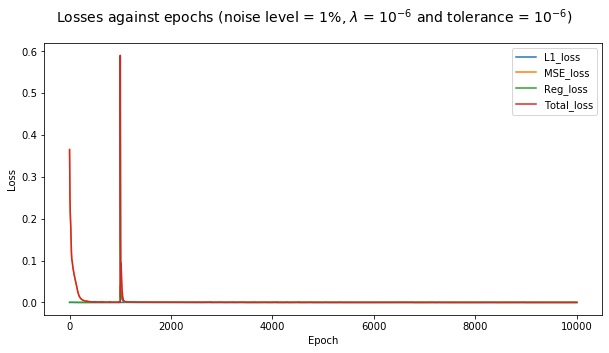

In [12]:
Total_loss = losses['Total_loss']
#print('Total Loss:', Total_loss)
L1_loss = losses['L1_loss']
MSE_loss = losses['MSE_loss']
Reg_loss = losses['Reg_loss']

plt.figure(figsize=(10, 5))
#plt.title('Losses against epochs (noise level = 1%, $\lambda$ = $10^{\mathrm{-6}}$ and tolerance = $10^{\mathrm{-6}}$)', fontsize=14)
plt.suptitle('Losses against epochs (noise level = 1%, $\lambda$ = $10^{\mathrm{-6}}$ and tolerance = $10^{\mathrm{-6}}$)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(L1_loss, label="L1_loss")
plt.plot(MSE_loss, label="MSE_loss")
plt.plot(Reg_loss, label="Reg_loss")
plt.plot(Total_loss, label="Total_loss")
plt.legend(loc='upper right')
plt.show()
